# B-Factor Analysis for PTE 2023 Paper


This notebook is used to extract the B-factors from PDBs associated with the PTE paper and plot them. 
Based on scripts obtained from Mahakaran Sandu. Edited by Joe Kaczmarski. 

In [1]:
### LOAD PACKAGES

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Bio.PDB import PDBParser
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import glob
import math
import pickle

In [2]:
#Define loop regions and resgions to exclude from B-factor analysis (start, end inclusive)

Nterm=[]
L1=[]
L2=[]
L3=[]
L4=[170,178]
L5=[200,210]
L6=[230,239]
L7=[257, 275]
L8=[]
Cterm=[]

L4l=174
L5l=205
L6l=234.5
L7l=266

In [3]:
#set color choice for plots
colors=["C0","C1","C2","C3"]

In [4]:
#DEFINE PDB NAMES AND ORDER and TRAJECTORIES

pdb_dict={'4PCP':'R0',
            '4XAF':'R1',
            '4XD5':'R2',
            '4XAG':'R6',
            '4XAY':'R8',
            '4XAZ':'R18',
            '4PCN':'R22',
            '4PBE':'Rev6',
            '4PBF':'Rev12',
            '4XD6':'E2a',
            '4XD3':'E3',
            '5W6B':'S1',
            '5WCQ':'S2',
            '5WCW':'S3',
            '5WIZ':'S5',
            '5WCP':'S6',
            '5WMS':'S7',
            '6AML':'S8',
            '6B2F':'S5+HLN',
            '5WJ0':'S5+254R',
            '6BH7':'R18+254S',
            '6BHL':'S5ΔL7',
            '6BHK':'R18ΔL7',
            '5WCR':'PTE(WT)ΔL7'}

input_pdbs = [key for key in pdb_dict]

Rtraj=['4PCP','4XAF','4XD5','4XAG', '4XAY','4XAZ','4PCN']
Straj=['5W6B', '5WCQ', '5WCW', '5WIZ', '5WCP', '5WMS', '6AML', '5WCR', '5WJ0', '6B2F', '6BHL']
allpdbs = ['5W6B', '5WCQ', '5WCW', '5WIZ', '5WCP', '5WMS', '6AML', '5WCR', '5WJ0', '6B2F', '6BHL','4PCP','4XAF','4XD5','4XAG', '4XAY','4XAZ','4PCN']

In [23]:
from pathlib import Path
### SET UP DATA EXTRACTION INPUT/OUTPUT
current_dir=Path.cwd()

# Set the paths for input and output folders
pdb_folder = f"{current_dir}/PDBs"
output_folder = f"{current_dir}/output"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

In [24]:
### RUN DATA EXTRACTION ###
# this extracts B-factors from PDB files. For cases where there are multiple conformers, removes alternate conformer B. Also extracts other information about PDB files that is used in PDB Summary Table. 

aminos = ['CYS', 'ASP', 'SER', 'GLN', 'LYS', 'ILE', 'PRO', 'THR', 'PHE','ASN', 'GLY', 'HIS', 'LEU', 'ARG', 'TRP', 'ALA', 'VAL', 'GLU', 'TYR', 'MET', 'KCX']
bad_res   = ['B'+i for i in aminos]

# def extract_pdb_summary(pdb_folder, output_folder):
summary_data = []
all_b_factors = []
all_residue_numbers = []
all_labels = []

#read all pdbs in input list by checking lines in PDB
for pdb_id in input_pdbs:
    pdb_summary=[]
    nickname=pdb_dict[pdb_id]
    pdblower=pdb_id.lower()
    filename=pdblower+".pdb"
    pdb_path = os.path.join(pdb_folder, filename)
    print(f'extracting data for {nickname} ({pdb_id}) from {pdb_path}')
    
    # Check for anisotropic B-factors by checking for "ANISOU" lines in PDB file
    anisou = "N"
    with open(pdb_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith('ANISOU'):
                anisou = 'Y'
                print(f"{nickname} has ANISOU")
                break
            
    # Check for TLS groups and refinement
    TLS_status="N"
    with open(pdb_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith('REMARK   3   TLS GROUP :') or line.startswith('REMARK   3   TLS DETAILS:'):
                TLS_status = 'Y'
                print(f'{nickname} has been refined with TLS')
                break
    
    # Check number of TLS groups
    number_of_tls=0
    with open(pdb_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith('REMARK   3   NUMBER OF TLS GROUPS'):
                # print(line.split(":")[-1])
                if line.split(":")[-1]==' NULL                                       \n':
                    print(f"{nickname} doesn't have TLS groups")
                    break
                else:
                    number_of_tls= int(line.split(":")[-1])
                    print(f"{nickname} has {number_of_tls} groups.")
                    break
            

    #extract resolution of PDB and b-factors from each chain in PDB using Bio.PDB Parser
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_path)
    # Check resolution
    resolution = structure.header["resolution"]
    print(f"{nickname} has resolution of {resolution} angstroms.")

    # Extract chain info
    chains = list(structure.get_chains())
    num_chains = len(chains)
    chain_ids = ",".join([chain.get_id() for chain in chains])
    print(f"{nickname} has {num_chains} chains: {chain_ids}.")


    #loop through chains in pdb and extract missing regions, and CA B-factors

    for chain in chains:
        chain_id=chain.get_id()
        #print(chain_id)
        residues = chain.get_residues()
        residue_b_factors = []
        residue_numbers = []
        missing_residue_regions = []
        prev_residue_number = None


        #check for missing residues/gaps in the PDB       
        start_missing = None
        for residue in residues:
            current_residue_number = residue.get_id()[1]
            if residue.has_id("CA"):
                if prev_residue_number is not None and current_residue_number - prev_residue_number > 1:
                    if start_missing is None:  # Start of a missing region
                        start_missing = prev_residue_number + 1
                    # Fill in missing residue numbers with B-factor -1
                    for missing_residue_number in range(prev_residue_number+1, current_residue_number):
                        residue_b_factors.append(-1)
                        residue_numbers.append(missing_residue_number)
                else:
                    if start_missing is not None:  # End of a missing region
                        missing_residue_regions.append((start_missing, prev_residue_number))
                        start_missing = None
                #adds bfactor and residue number to list
                residue_b_factors.append(residue["CA"].get_bfactor() if residue["CA"].get_bfactor() != 0 else -1)
                residue_numbers.append(current_residue_number)

            prev_residue_number = current_residue_number

        # If a missing region extends to the last residue
        if start_missing is not None:
            missing_residue_regions.append((start_missing, prev_residue_number))

        missing_residue_regions_str = ', '.join([f"{start}-{end}" for start, end in missing_residue_regions])

    
        # Exclude any B-factors with value -1 when calculating the average B-factor
        valid_b_factors = [bf for bf in residue_b_factors if bf != -1]

        avg_b_factor = np.mean(valid_b_factors) if valid_b_factors else 0
            

        # Create residue-level B-factor file
        residue_data = list(zip(residue_numbers, residue_b_factors))
        residue_df = pd.DataFrame(residue_data, columns=["Residue Number", "B-Factor"])
        residue_filename = os.path.join(output_folder, f"{pdb_id}_{chain.get_id()}_PDBBfactor.csv")
        residue_df.to_csv(residue_filename, index=False)    

        print(f"Data extracted from chain {chain_id} of {nickname}.")

        #Add b-factors to lists for plots
        all_residue_numbers.append(residue_numbers)
        all_b_factors.append(residue_b_factors)
        chain_label=str(f"{nickname} ({pdb_id})_{chain_id}")
        all_labels.append(chain_label)

        #update summary table
        summary_data.append((nickname, pdb_id, resolution, TLS_status, number_of_tls, anisou, num_chains, chain_ids, chain_id, round(avg_b_factor,2), missing_residue_regions_str, residue_numbers, residue_b_factors, chain_label))

    
    print(f"Data extracted from all chains of {nickname}. \n ")

#PRINT SUMMARY TABLE FILE
# update the data and column names for the summary_df
summary_df = pd.DataFrame(
summary_data, columns=["NAME", "PDB ID", "Resolution","TLS", "#TLS groups", "ANISOU", "Number of Chains", "Chain IDs", "Chain ID", "Average B-Factor",  "Missing Residue Regions", "Residue Numbers", "Isotropic B-factor data", "Labels"]
)
chain_summary_filename = os.path.join(output_folder, "PTE_PDBchain_Summary.csv")
per_pdb_summary_filename = os.path.join(output_folder, "PTE_PDB_Summary.csv")

summary_df.to_csv(chain_summary_filename, index=False, columns=["NAME", "PDB ID", "Resolution","#TLS groups", "ANISOU", "Chain ID", "Average B-Factor",  "Missing Residue Regions"])
summary_df.to_csv(per_pdb_summary_filename, index=False, columns=["NAME", "PDB ID", "Resolution","#TLS groups", "ANISOU", "Chain IDs"])
print("\nSummary Tables Saved \n")
print("Data extracted from all PDBs in list. \n \n")


extracting data for R0 (4PCP) from /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/PDBs/4pcp.pdb
R0 has resolution of None angstroms.
R0 has 2 chains: A,G.
Data extracted from chain A of R0.
Data extracted from chain G of R0.
Data extracted from all chains of R0. 
 
extracting data for R1 (4XAF) from /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/PDBs/4xaf.pdb
R1 has resolution of None angstroms.
R1 has 2 chains: A,G.
Data extracted from chain A of R1.
Data extracted from chain G of R1.
Data extracted from all chains of R1. 
 
extracting data for R2 (4XD5) from /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/PDBs/4xd5.pdb
R2 has resolution of None angstroms.
R2 has 2 chains: A,G.
Data extracted from chain A of R2.
Data extracted from 

In [7]:
# SHOW DATA
summary_df

,NAME,PDB ID,Resolution,TLS,#TLS groups,ANISOU,Number of Chains,Chain IDs,Chain ID,Average B-Factor,Missing Residue Regions,Residue Numbers,Isotropic B-factor data,Labels
0,R0,4PCP,None,N,0,N,2,"A,G",A,24.42,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[76.75, 68.61, 31.2, 15.93, 14.8, 14.55, 14.05...",R0 (4PCP)_A
1,R0,4PCP,None,N,0,N,2,"A,G",G,20.70,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[52.88, 47.68, 32.73, 22.6, 21.5, 13.76, 14.19...",R0 (4PCP)_G
2,R1,4XAF,None,N,0,N,2,"A,G",A,27.72,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[68.55, 58.71, 32.45, 17.2, 16.3, 17.5, 16.9, ...",R1 (4XAF)_A
3,R1,4XAF,None,N,0,N,2,"A,G",G,21.14,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[52.21, 38.85, 28.99, 23.15, 22.12, 15.49, 14....",R1 (4XAF)_G
4,R2,4XD5,None,N,0,N,2,"A,G",A,23.18,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[55.9, 65.21, 29.39, 14.79, 12.36, 13.45, 8.58...",R2 (4XD5)_A
5,R2,4XD5,None,N,0,N,2,"A,G",G,19.62,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[56.66, 43.54, 32.44, 21.23, 19.85, 13.49, 11....",R2 (4XD5)_G
6,R6,4XAG,None,N,0,N,2,"A,G",A,19.33,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[52.83, 38.25, 21.83, 15.67, 12.66, 13.9, 10.5...",R6 (4XAG)_A
7,R6,4XAG,None,N,0,N,2,"A,G",G,17.69,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[41.04, 46.04, 17.04, 18.82, 16.28, 12.88, 11....",R6 (4XAG)_G
8,R8,4XAY,None,N,0,N,2,"A,G",A,26.27,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[68.18, 55.61, 31.36, 19.66, 19.12, 15.41, 15....",R8 (4XAY)_A
9,R8,4XAY,None,N,0,N,2,"A,G",G,24.45,,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[54.8, 64.71, 45.44, 29.36, 19.04, 15.12, 16.7...",R8 (4XAY)_G


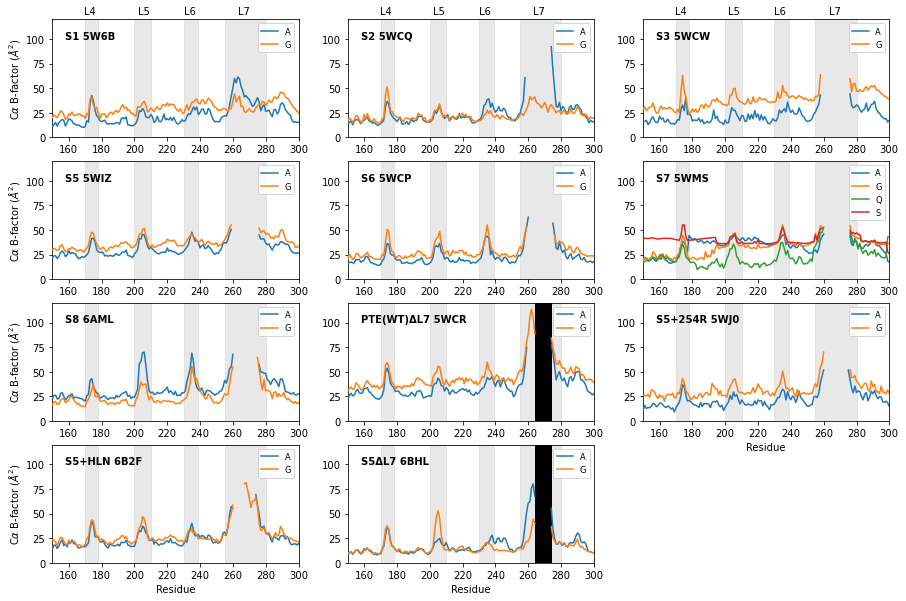

In [25]:
# PLOTTING UNNORMALISED B-FACTORS (S-TRAJ)
#This cell is used for deciding on places in multipanel figure

places = [1+i for i in range(len(Straj))]
#print(places)
csv_df = pd.DataFrame()

ymin=0
ymax=120
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1


# loop through each PDB ID
for pdb_id in Straj:

    

    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    #print(f"working on {pdb_id}")

    place = places[Straj.index(pdb_id)]    
    ax = fig.add_subplot(4,3,place)
    
    color_count=0
    for chain_id in pdb_rows['Chain ID'].unique():
        #print(f"working on {chain_id}")
        column_label = f"{pdb_id}_{nickname}_{chain_id}"
        residue_col_label=f"res_{pdb_id}_{nickname}_{chain_id}"
        # Get the rows corresponding to the current CHAIN ID and PDB ID
        chain_rows = pdb_rows[pdb_rows['Chain ID'] == chain_id]
        # nickname = chain_rows['NAME'].iloc[0]
        #print(nickname)

        # plot_chain_bfactor, ax1 = plt.subplots()
        dataf = pd.DataFrame({'Residue Numbers': chain_rows['Residue Numbers'], 'Isotropic B-factor data': chain_rows['Isotropic B-factor data']})
        #print(dataf['Residue Numbers'].iloc[0])
        #print(dataf['Isotropic B-factor data'].iloc[0])

        residue_numbers_series = pd.Series(dataf['Residue Numbers'].iloc[0])
        csv_df[residue_col_label] = residue_numbers_series
        
        b_factors_series = pd.Series(dataf['Isotropic B-factor data'].iloc[0])
        csv_df[column_label] = b_factors_series
        #print("this is what is should look like before replacing with nan")
        #print(b_factors_series)
        b_factors_series = b_factors_series.replace(-1, np.nan)
        b_factors_list = list(b_factors_series)

        #interpolate in missing regions
        interpolated_points=[]
        interpolated_range=[]
        interpolated_b_factors = b_factors_series.interpolate()
        interpolated_points = b_factors_series.isna() & interpolated_b_factors.notna()
        #print("intopolated points are")
        #print(interpolated_points)
        non_missing_mask = b_factors_series.notna()

       
        # # Plot missing residues (B-factor equal to NaN interpolated)
        if True in interpolated_points:
            # Find the indices where interpolated points are True
            interpolated_indices = [i for i, val in enumerate(interpolated_points) if val]
            
            # Check if there are any missing regions
            if len(interpolated_indices) > 0:
                # Initialize variables for storing the start and end indices of each missing region
                missing_start = interpolated_indices[0]
                missing_end = interpolated_indices[0]
                
                # Loop through the interpolated indices to identify missing regions
                for index in interpolated_indices[1:]:
                    if index == missing_end + 1:
                        missing_end = index
                    else:
                        # Plot the missing region
                        ax.plot(residue_numbers_series.iloc[missing_start:missing_end+1], interpolated_b_factors.iloc[missing_start-1:missing_end+2], 'k:')
                        
                        # Update the start and end indices for the next missing region
                        missing_start = index
                        missing_end = index
                
                # Plot the last missing region
                # ax.plot(residue_numbers_series.iloc[missing_start-1:missing_end+2], interpolated_b_factors.iloc[missing_start-1:missing_end+2], 'k')
         
                # Plot non-missing residues
                # ax.scatter(residue_numbers_series[non_missing_mask], b_factors_series[non_missing_mask], label=f"{chain_id}",color=colors[color_count], zorder=5)
                ax.plot(residue_numbers_series[:missing_start], b_factors_series[:missing_start], label=f"{chain_id}",color=colors[color_count], zorder=5)
                ax.plot(residue_numbers_series[missing_end:], b_factors_series[missing_end:],color=colors[color_count], zorder=5)
            else:
                ax.plot(residue_numbers_series, b_factors_series, label=f"{chain_id}",color=colors[color_count], zorder=5)
        color_count=color_count+1

    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas
    ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
    ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    
    # if count in [12,13]:
    #     ax.axvspan(255, 271, alpha=0.5, color='lightgray', zorder=1)
    # else: 
    #     ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    #sets labels on axes    
    if count in [1,4,7,10]:
        ax.set_ylabel(r"C$\alpha$ B-factor ($\AA^2$)")
    if count in [9,10,11,12]:
        ax.set_xlabel('Residue')
    if count in [1,2,3]:
        ax.text(169.5, ymax+5, 'L4')
        ax.text(202, ymax+5, 'L5')
        ax.text(230, ymax+5, 'L6')
        ax.text(263, ymax+5, 'L7')    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)
    ax.text(xmin+8, 100, nickname+' '+pdb_id,fontweight='bold')
    ax.legend(loc='upper right', fontsize='small', markerscale=0.5)
    
    

    if pdb_id in ["5WCR","6BHL","6BHK"]:
        ax.axvspan(264, 274, color='black', zorder=1)
    count = count+1

# Save the DataFrame to a CSV file
csv_df.to_csv(f'{output_folder}/Straj_Bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Straj_Bfactors_allchains.png', dpi=300)   


In [21]:
print(output_folder)
!pwd

output
/Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis


In [27]:
import glob
import csv
import math
import numpy as np

# Define the path to the folder containing the CSV files
folder_path = f'{output_folder}/'

# Define the pdb_id you're interested in
for pdb_id in allpdbs:

    # Create a list to store the data from all the CSV files
    data = []

    # Find all CSV files starting with the specified pdb_id
    file_pattern = f"{folder_path}{pdb_id}_*.csv"
    file_list = glob.glob(file_pattern)

    # Iterate over each file and read the data
    for file_name in file_list:
        with open(file_name, 'r') as file:
            csv_reader = csv.reader(file)
            next(csv_reader)  # Skip the header row
            for row in csv_reader:
                residue_number = int(row[0])
                b_factor = float(row[1])
                
                # Replace -1 with NaN (or equivalent)
                if b_factor == -1:
                    b_factor = math.nan
                
                data.append((residue_number, b_factor))

    # Sort the data by residue number
    data.sort(key=lambda x: x[0])

    # Calculate the average and standard deviation for each residue number
    result = []
    current_residue = None
    b_factors = []
    for residue, b_factor in data:
        if residue != current_residue:
            if current_residue is not None:
                avg_b_factor = np.nanmean(b_factors)
                std_dev = np.nanstd(b_factors)
                result.append((current_residue, avg_b_factor, std_dev))
            current_residue = residue
            b_factors = []
        b_factors.append(b_factor)

    # Add the last residue's data
    if current_residue is not None:
        avg_b_factor = np.nanmean(b_factors)
        std_dev = np.nanstd(b_factors)
        result.append((current_residue, avg_b_factor, std_dev))

    # Write the result to a new CSV file
    output_file = f"{folder_path}averages/{pdb_id}_averages.csv"
    with open(output_file, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(["Residue Number", "Average B-Factor", "Standard Deviation"])
        csv_writer.writerows(result)

    print(f"Result saved to {output_file}")


Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averages/5W6B_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averages/5WCQ_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averages/5WCW_averages.csv


/var/folders/4n/4433n5s52nb5jmvl26fpws3wkmhhcf/T/ipykernel_77946/39631017.py:44: RuntimeWarning: Mean of empty slice
  avg_b_factor = np.nanmean(b_factors)
/Users/u4855540/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averages/5WIZ_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averages/5WCP_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averages/5WMS_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averages/6AML_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averages/5WCR_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUnive

12


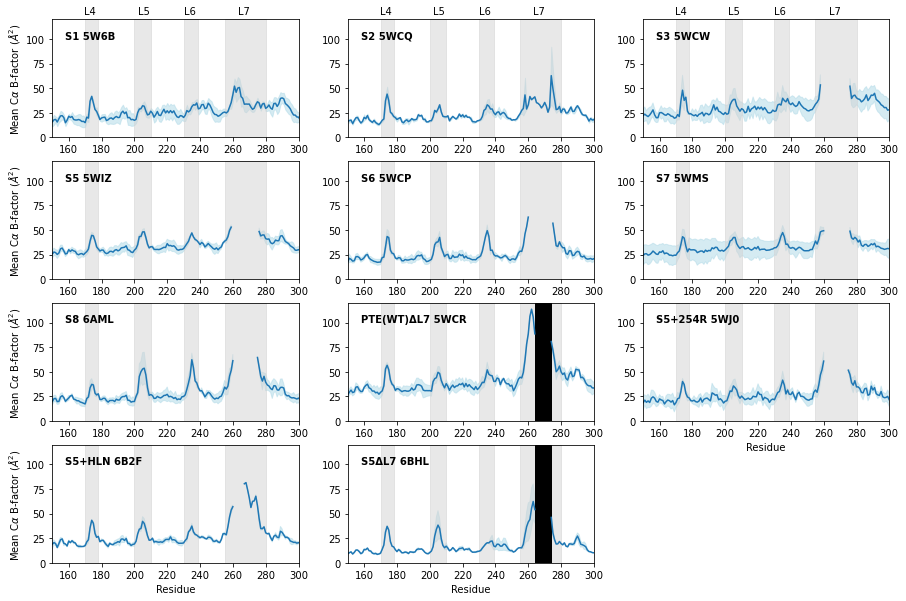

In [28]:
# PLOTTING AVERAGE UNNORMALISED B-FACTORS (S-TRAJ)
#This cell is used for deciding on places in multipanel figure

places = [1+i for i in range(len(Straj))]

ymin=0
ymax=120
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1


# loop through each PDB ID
for pdb_id in Straj:

    file_name=f'{output_folder}/averages/{pdb_id}_averages.csv'
    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    #print(f"working on {pdb_id}")

    place = places[Straj.index(pdb_id)]    
    ax = fig.add_subplot(4,3,place)
    
    data= pd.read_csv(file_name)
    residue_number = data['Residue Number']
    average_bfactor = data['Average B-Factor']
    std_dev = data['Standard Deviation']
    ax.plot(residue_number, average_bfactor)
    # Create an array for the shaded region
    x = np.array(residue_number)
    y1 = average_bfactor - std_dev
    y2 = average_bfactor + std_dev

    # Shade the region within plus and minus standard deviation
    ax.fill_between(x, y1, y2, color='lightblue', alpha=0.5)

        

    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas
    ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
    ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)

        
        
    if count in [8,12,13]:
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    else: 
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    #sets labels on axes    
    if count in [1,4,7,10]:
        ax.set_ylabel(r"Mean C$\alpha$ B-factor ($\AA^2$)")
    if count in [9,10,11,12]:
        ax.set_xlabel('Residue')
    if count in [1,2,3]:
        ax.text(169.5, ymax+5, 'L4')
        ax.text(202, ymax+5, 'L5')
        ax.text(230, ymax+5, 'L6')
        ax.text(263, ymax+5, 'L7')    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)
    ax.text(xmin+8, 100, nickname+' '+pdb_id,fontweight='bold')
    # ax.legend(loc='upper right', fontsize='small', markerscale=0.5)
    
    color_count=color_count+1
    count = count+1

    if pdb_id in ["5WCR","6BHL","6BHK"]:
        ax.axvspan(264, 274, color='black', zorder=1)

print(count)



# Save the DataFrame to a CSV file
#csv_df.to_csv('Straj_Bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Straj_AVERAGE_Bfactors_allchains.png', dpi=300)   


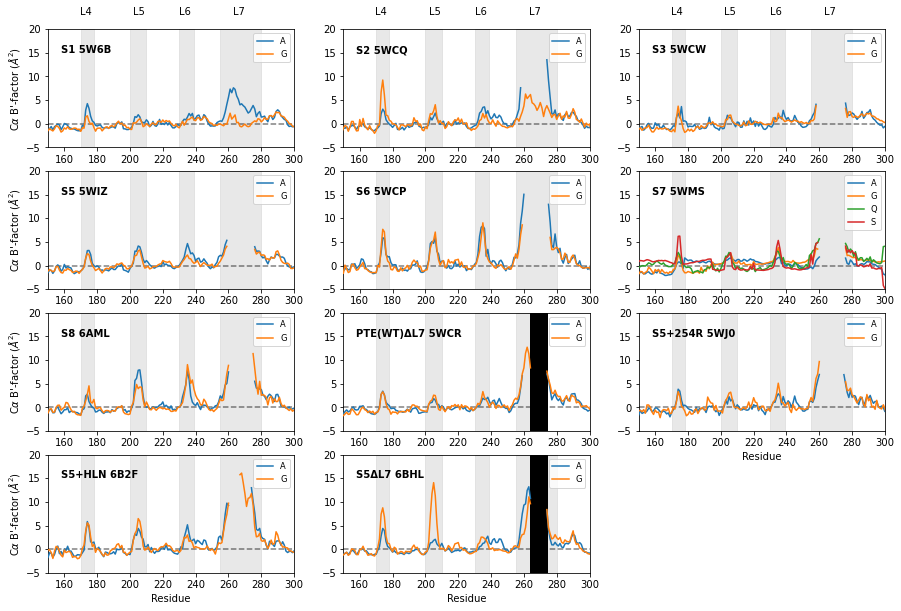

In [33]:
# PLOTTING BASELINE-NORMALISED B-FACTORS (S-TRAJ)
#This cell is used for deciding on places in multipanel figure

places = [1+i for i in range(len(Straj))]
#print(places)
csv_df = pd.DataFrame()
ymin=-5
ymax=20
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1


# loop through each PDB ID
for pdb_id in Straj:
    

    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    # print(f"working on {nickname} ({pdb_id})")

    place = places[Straj.index(pdb_id)]    
    ax = fig.add_subplot(4,3,place)
    color_count=0
    for chain_id in pdb_rows['Chain ID'].unique():
        pdb_df=pd.DataFrame()
        # print(f"working on {chain_id}")
        # Get the rows corresponding to the current CHAIN ID and PDB ID
        chain_rows = pdb_rows[pdb_rows['Chain ID'] == chain_id]
        column_label = f"{pdb_id}_{nickname}_{chain_id}"
        residue_col_label=f"res_{pdb_id}_{nickname}_{chain_id}"
        
        residue_numbers= chain_rows["Residue Numbers"].iloc[0]
        b_factors = chain_rows["Isotropic B-factor data"].iloc[0]
        # # print("resi numbers")
        # print(residue_numbers)
        # print("bfact")
        # print(b_factors)

        # Filter the residue numbers and B-factors based on omitted regions
        omitted_regions=[(0,150),(170,178),(200,210),(230,239),(255,280),(300,450)]


        filtered_residue_numbers = []
        filtered_b_factors = []
        for num, b_factor in zip(residue_numbers, b_factors):
            if not any(start <= num <= end for start, end in omitted_regions):
                filtered_residue_numbers.append(num)
                filtered_b_factors.append(b_factor)

        # Calculate the average isotropic B-factor
        average_b_factor = np.mean(filtered_b_factors)
        sd_b_factor=np.std(filtered_b_factors)
        # print(filtered_residue_numbers)
        # print(average_b_factor)
    
        # Create a new list of normalised B-factors
        normalised_b_factors = [(b_factor - average_b_factor)/sd_b_factor for b_factor in b_factors]
        # print("this is normzlised")
        # print(normalised_b_factors)

        # residue_numbers_series = pd.Series(dataf['Residue Numbers'].iloc[0])
        residue_numbers_series = pd.Series(chain_rows['Residue Numbers'].iloc[0])
        # print("this is residue numbers series")
        # print(residue_numbers_series)
        b_factors_series = pd.Series(normalised_b_factors)
        b_factors_series2 = pd.Series(b_factor for b_factor in b_factors)
        pdb_df[residue_col_label] = residue_numbers_series
        pdb_df[column_label] = b_factors_series.replace((-1 - average_b_factor)/sd_b_factor, -1)
        csv_df[residue_col_label] = residue_numbers_series
        csv_df[column_label] = b_factors_series


        # print("this is norm bfactor series")
        # print(b_factors_series)
        value_of_missing=-1
        b_factors_series2 = b_factors_series2.replace(value_of_missing, np.nan)
        # print(b_factors_series)


         #interpolate in missing regions
        interpolated_points=[]
        interpolated_range=[]
        interpolated_b_factors = b_factors_series.interpolate()
        interpolated_points = b_factors_series2.isna() & interpolated_b_factors.notna()
        # print(interpolated_b_factors)
        # print("intopolated points are")
        # print(interpolated_points[150:200])
        non_missing_mask = b_factors_series2.notna()
        # print("this is non missing mask")
        # print(non_missing_mask)

        # Plot missing residues (B-factor equal to NaN interpolated)
        if True in interpolated_points:
            # Find the indices where interpolated points are True
            interpolated_indices = [i for i, val in enumerate(interpolated_points) if val]
            
            # Check if there are any missing regions
            if len(interpolated_indices) > 0:
                # Initialize variables for storing the start and end indices of each missing region
                missing_start = interpolated_indices[0]
                missing_end = interpolated_indices[0]
                
                # Loop through the interpolated indices to identify missing regions
                for index in interpolated_indices[1:]:
                    if index == missing_end + 1:
                        missing_end = index
                    else:
                        # Plot the missing region
                        ax.plot(residue_numbers_series.iloc[missing_start:missing_end+1], interpolated_b_factors.iloc[missing_start-1:missing_end+2], 'k:')
                        
                        # Update the start and end indices for the next missing region
                        missing_start = index
                        missing_end = index
                
                # Plot the last missing region
                # ax.plot(residue_numbers_series.iloc[missing_start-1:missing_end+2], interpolated_b_factors.iloc[missing_start-1:missing_end+2], 'k')
                ax.plot(residue_numbers_series[:missing_start], b_factors_series[:missing_start],color=colors[color_count], zorder=5)
                ax.plot(residue_numbers_series[missing_end+1:], b_factors_series[missing_end+1:], label=f"{chain_id}",color=colors[color_count], zorder=5)
            else:
                ax.plot(residue_numbers_series, b_factors_series, label=f"{chain_id}",color=colors[color_count], zorder=5)
            color_count=color_count+1
        
      
       # Plot non-missing residues
        # ax.scatter(residue_numbers_series[non_missing_mask], b_factors_series[non_missing_mask], label=f"{chain_id}",color=colors[color_count], zorder=5)
        # print(missing_start)
        # print(missing_end)`
          
        

        
        
        pdb_df.to_csv(f'{output_folder}/averagenorm/{pdb_id}_{chain_id}_Straj_Normalised_S-traj_bfactors_data_perchain.csv', index=False)   
    
    
    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas
    ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
    ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)
    plt.axhline(y=0, color='k', alpha=0.5, linestyle='dashed')
    
    if count in [8,12,13]:
        ax.axvspan(255, 271, alpha=0.5, color='lightgray', zorder=1)
    else: 
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    #sets labels on axes    
    if count in [1,4,7,10]:
        ax.set_ylabel(r"C$\alpha$ B'-factor ($\AA^2$)")
    if count in [9,10,11,12]:
        ax.set_xlabel('Residue')
    if count in [1,2,3]:
        ax.text(169.5, ymax+3, 'L4')
        ax.text(202, ymax+3, 'L5')
        ax.text(230, ymax+3, 'L6')
        ax.text(263, ymax+3, 'L7')    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)
    ax.text(xmin+8, ymax-5, nickname+' '+pdb_id,fontweight='bold')
    ax.legend(loc='upper right', fontsize='small', markerscale=0.5)
    
    if pdb_id in ["5WCR","6BHL","6BHK"]:
        ax.axvspan(264, 274, color='black', zorder=1)
    count = count+1

# Save the DataFrame to a CSV file
csv_df.to_csv(f'{output_folder}/Straj_Normalised_S-traj_bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Straj_Normalized-Bfactors_allchains.png', dpi=300)   


12


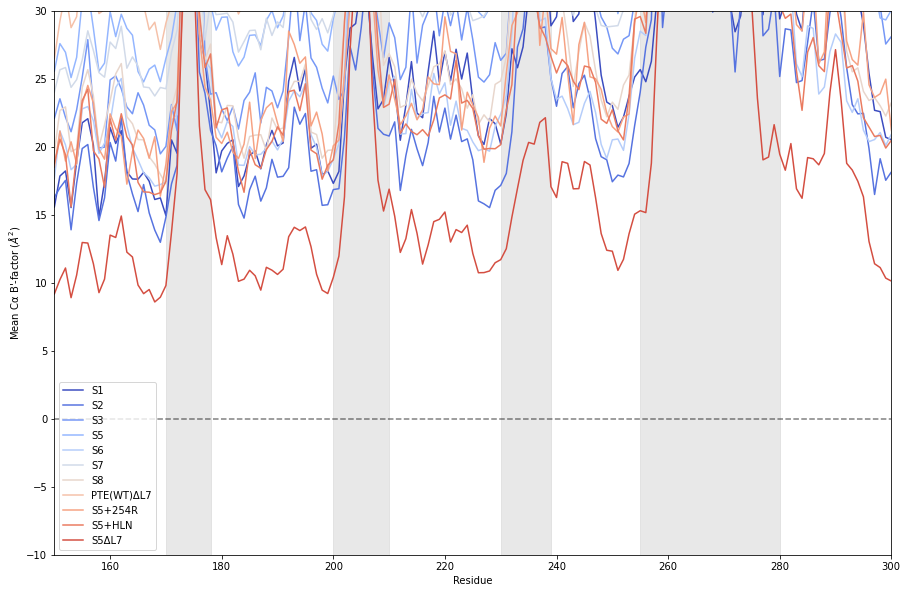

In [34]:
# PLOTTING AVERAGE NORMALISED B-FACTORS (R-TRAJ)
#This cell is used for deciding on places in multipanel figure
color=iter(plt.cm.coolwarm(np.linspace(0,1,12)))

ymin=-10
ymax=30
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1
ax = fig.add_subplot(111)

# loop through each PDB ID
for pdb_id in Straj:

    file_name=f"{output_folder}/averages/{pdb_id}_averages.csv"
    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    #print(f"working on {pdb_id}")

    # place = places[Rtraj.index(pdb_id)]    
    # ax = fig.add_subplot(4,3,place)
    
    data= pd.read_csv(file_name)
    residue_number = data['Residue Number']
    average_bfactor = data['Average B-Factor']
    # std_dev = data['Standard Deviation']
    c=next(color)
    ax.plot(residue_number, average_bfactor, color=c, label=nickname)
    # Create an array for the shaded region
    # x = np.array(residue_number)
    # y1 = average_bfactor - std_dev
    # y2 = average_bfactor + std_dev

    # Shade the region within plus and minus standard deviation
    # ax.fill_between(x, y1, y2, color='lightblue', alpha=0.5)

   
    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas


        
        
    # if count in [8,12,13]:
    #     ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    # else: 
    #     ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    # #sets labels on axes    
    # if count in [1,4,7,10]:
    #     ax.set_ylabel(r"C$\alpha$ B'-factor ($\AA^2$)")
    # if count in [10,11,12]:
    #     ax.set_xlabel('Residue')
    # if count in [1,2,3]:
    #     ax.text(169.5, ymax+5, 'L4')
    #     ax.text(202, ymax+5, 'L5')
    #     ax.text(230, ymax+5, 'L6')
    #     ax.text(263, ymax+5, 'L7')    

    # ax.text(xmin+8, ymax*0.8, nickname+' '+pdb_id,fontweight='bold')
    # # ax.legend(loc='upper right', fontsize='small', markerscale=0.5)


    # if pdb_id in ["5WCR","6BHL","6BHK"]:
    #     ax.axvspan(264, 274, color='black', zorder=1)

    color_count=color_count+1
    count = count+1



ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)
ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin,xmax)
ax.set_ylabel("Mean Cα B'-factor ($\AA^2$)")
ax.set_xlabel("Residue")
plt.legend()
plt.axhline(y=0, color='k', alpha=0.5, linestyle='dashed')
print(count)



# Save the DataFrame to a CSV file
#csv_df.to_csv('Straj_Bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Straj_AVERAGENORM_Bfactors_compare.png', dpi=300)   


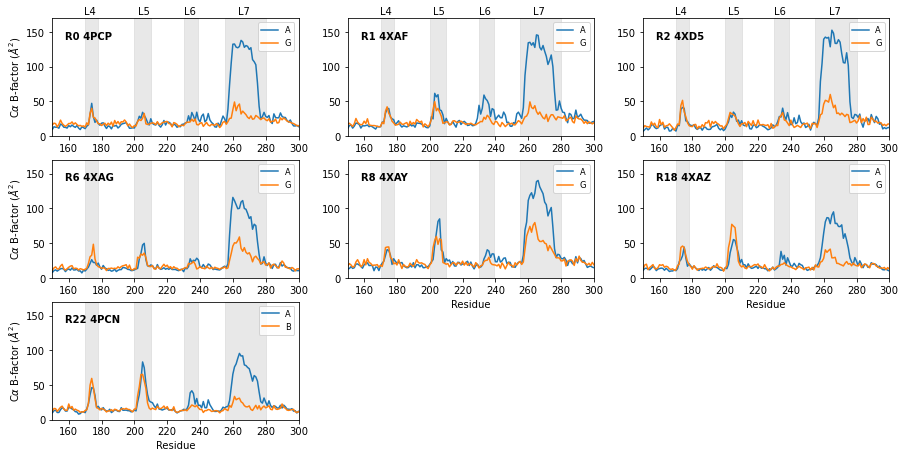

In [35]:
# PLOTTING UNNORMALISED B-FACTORS (R-TRAJ)
#This cell is used for deciding on places in multipanel figure

places = [1+i for i in range(len(Rtraj))]
# print(places)
csv_df = pd.DataFrame()

ymin=0
ymax=170
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1


# loop through each PDB ID
for pdb_id in Rtraj:

    

    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    # print(f"working on {pdb_id}")

    place = places[Rtraj.index(pdb_id)]    
    ax = fig.add_subplot(4,3,place)
    
    
    for chain_id in pdb_rows['Chain ID'].unique():
        # print(f"working on {chain_id}")
        column_label = f"{pdb_id}_{nickname}_{chain_id}"
        residue_col_label=f"res_{pdb_id}_{nickname}_{chain_id}"
        # Get the rows corresponding to the current CHAIN ID and PDB ID
        chain_rows = pdb_rows[pdb_rows['Chain ID'] == chain_id]
        # nickname = chain_rows['NAME'].iloc[0]
        # print(nickname)

        # plot_chain_bfactor, ax1 = plt.subplots()
        dataf = pd.DataFrame({'Residue Numbers': chain_rows['Residue Numbers'], 'Isotropic B-factor data': chain_rows['Isotropic B-factor data']})
        # print(dataf['Residue Numbers'].iloc[0])
        # print(dataf['Isotropic B-factor data'].iloc[0])

        residue_numbers_series = pd.Series(dataf['Residue Numbers'].iloc[0])
        csv_df[residue_col_label] = residue_numbers_series
        
        b_factors_series = pd.Series(dataf['Isotropic B-factor data'].iloc[0])
        csv_df[column_label] = b_factors_series
        # print("this is what is should look like before replacing with nan")
        # print(b_factors_series)
        b_factors_series = b_factors_series.replace(-1, np.nan)
        b_factors_list = list(b_factors_series)

        #interpolate in missing regions
        interpolated_points=[]
        interpolated_range=[]
        interpolated_b_factors = b_factors_series.interpolate()
        interpolated_points = b_factors_series.isna() & interpolated_b_factors.notna()
        # print("intopolated points are")
        # print(interpolated_points)
        non_missing_mask = b_factors_series.notna()

        # Plot non-missing residues
        
        ax.plot(residue_numbers_series[non_missing_mask], b_factors_series[non_missing_mask], label=f"{chain_id}")
        
        # Plot missing residues (B-factor equal to NaN interpolated)
        if True in interpolated_points:
            # Find the indices where interpolated points are True
            interpolated_indices = [i for i, val in enumerate(interpolated_points) if val]
            
            # Check if there are any missing regions
            if len(interpolated_indices) > 0:
                # Initialize variables for storing the start and end indices of each missing region
                missing_start = interpolated_indices[0]
                missing_end = interpolated_indices[0]
                
                # Loop through the interpolated indices to identify missing regions
                for index in interpolated_indices[1:]:
                    if index == missing_end + 1:
                        missing_end = index
                    else:
                        # Plot the missing region
                        ax.plot(residue_numbers_series.iloc[missing_start:missing_end+1], interpolated_b_factors.iloc[missing_start-1:missing_end+2], 'k:')
                        
                        # Update the start and end indices for the next missing region
                        missing_start = index
                        missing_end = index
                
                # Plot the last missing region
                ax.plot(residue_numbers_series.iloc[missing_start-1:missing_end+2], interpolated_b_factors.iloc[missing_start-1:missing_end+2], 'k')



        

    if pdb_id in ["5WCR","6BHL","6BHK"]:
        ax.axvspan(264, 273, color='black', zorder=1)
    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas
    ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
    ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)

    
    
    if count in [8,12,13]:
        ax.axvspan(255, 271, alpha=0.5, color='lightgray', zorder=1)
    else: 
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    #sets labels on axes    
    if count in [1,4,7,10]:
        ax.set_ylabel(r"C$\alpha$ B-factor ($\AA^2$)")
    if count in [5,6,7]:
        ax.set_xlabel('Residue')
    if count in [1,2,3]:
        ax.text(169.5, ymax+5, 'L4')
        ax.text(202, ymax+5, 'L5')
        ax.text(230, ymax+5, 'L6')
        ax.text(263, ymax+5, 'L7')    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)
    ax.text(xmin+8, ymax-30, nickname+' '+pdb_id,fontweight='bold')
    ax.legend(loc='upper right', fontsize='small', markerscale=0.5)
    count = count+1

# Save the DataFrame to a CSV file
csv_df.to_csv('Rtraj_bfactors_data_perchain.csv', index=False)


plt.savefig(f'{output_folder}/Rtraj_bfactors_allchains.png', dpi=300)   


8


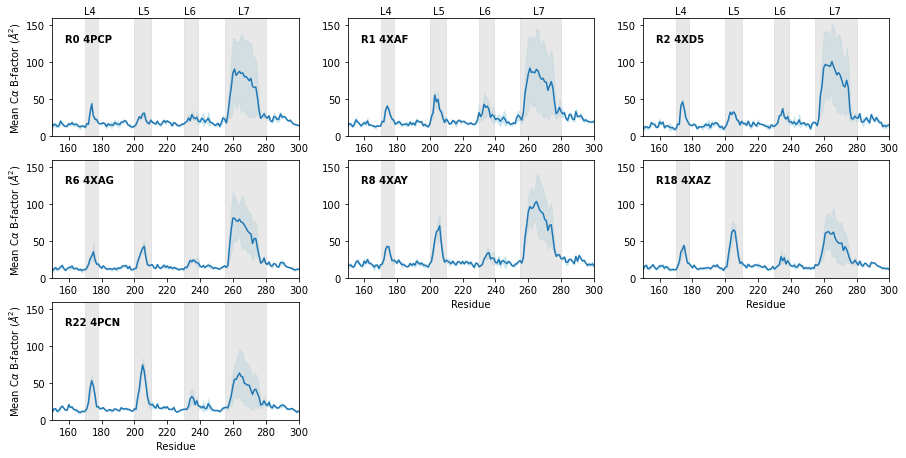

In [36]:
# PLOTTING AVERAGE UNNORMALISED B-FACTORS (S-TRAJ)
#This cell is used for deciding on places in multipanel figure

places = [1+i for i in range(len(Straj))]

ymin=0
ymax=160
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1


# loop through each PDB ID
for pdb_id in Rtraj:

    file_name=f'{output_folder}/averages/{pdb_id}_averages.csv'
    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    #print(f"working on {pdb_id}")

    place = places[Rtraj.index(pdb_id)]    
    ax = fig.add_subplot(4,3,place)
    
    data= pd.read_csv(file_name)
    residue_number = data['Residue Number']
    average_bfactor = data['Average B-Factor']
    std_dev = data['Standard Deviation']
    ax.plot(residue_number, average_bfactor)
    # Create an array for the shaded region
    x = np.array(residue_number)
    y1 = average_bfactor - std_dev
    y2 = average_bfactor + std_dev

    # Shade the region within plus and minus standard deviation
    ax.fill_between(x, y1, y2, color='lightblue', alpha=0.5)

    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas
    ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
    ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)

        
        
    if count in [8,12,13]:
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    else: 
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    #sets labels on axes    
    if count in [1,4,7,10]:
        ax.set_ylabel(r"Mean C$\alpha$ B-factor ($\AA^2$)")
    if count in [5,6,7,10,11,12]:
        ax.set_xlabel('Residue')
    if count in [1,2,3]:
        ax.text(169.5, ymax+5, 'L4')
        ax.text(202, ymax+5, 'L5')
        ax.text(230, ymax+5, 'L6')
        ax.text(263, ymax+5, 'L7')    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)
    ax.text(xmin+8, ymax*0.8, nickname+' '+pdb_id,fontweight='bold')
    # ax.legend(loc='upper right', fontsize='small', markerscale=0.5)
    
    color_count=color_count+1
    count = count+1

    if pdb_id in ["5WCR","6BHL","6BHK"]:
        ax.axvspan(264, 274, color='black', zorder=1)

print(count)



# Save the DataFrame to a CSV file
#csv_df.to_csv('Straj_Bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Rtraj_AVERAGEBfactors_allchains.png', dpi=300)   


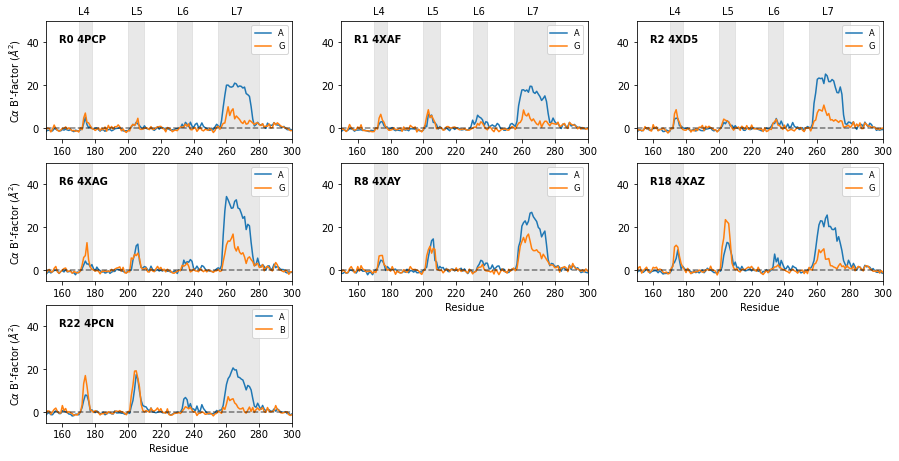

In [38]:
# PLOTTING BASELINE-NORMALISED B-FACTORS (S-TRAJ)
#This cell is used for deciding on places in multipanel figure

places = [1+i for i in range(len(Rtraj))]
# print(places)
csv_df = pd.DataFrame()
ymin=-5
ymax=50
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
# fig2 = plt.figure(figsize=(15,10))
count=1


# loop through each PDB ID
for pdb_id in Rtraj:

    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    # print(f"working on {nickname} ({pdb_id})")

    place = places[Rtraj.index(pdb_id)]    
    ax = fig.add_subplot(4,3,place)
    # ax2 = fig2.add_subplot(4,3,place)
    
    for chain_id in pdb_rows['Chain ID'].unique():
        pdb_df=pd.DataFrame()
        # print(f"working on {chain_id}")
        # Get the rows corresponding to the current CHAIN ID and PDB ID
        chain_rows = pdb_rows[pdb_rows['Chain ID'] == chain_id]
        column_label = f"{pdb_id}_{nickname}_{chain_id}"
        residue_col_label=f"res_{pdb_id}_{nickname}_{chain_id}"
        
        residue_numbers= chain_rows["Residue Numbers"].iloc[0]
        b_factors = chain_rows["Isotropic B-factor data"].iloc[0]
        # print("resi numbers")
        # print(residue_numbers)
        # print("bfact")
        # print(b_factors)

        # Filter the residue numbers and B-factors based on omitted regions
        omitted_regions=[(0,150),(170,178),(200,210),(230,239),(255,280),(300,450)]


        filtered_residue_numbers = []
        filtered_b_factors = []
        for num, b_factor in zip(residue_numbers, b_factors):
            if not any(start <= num <= end for start, end in omitted_regions):
                filtered_residue_numbers.append(num)
                filtered_b_factors.append(b_factor)

        # Calculate the average isotropic B-factor
        average_b_factor = np.mean(filtered_b_factors)
        sd_b_factor=np.std(filtered_b_factors)
        # print(filtered_residue_numbers)
        # print(average_b_factor)
    
        # Create a new list of normalised B-factors
        normalised_b_factors = [(b_factor - average_b_factor)/sd_b_factor for b_factor in b_factors]
        # print("this is normzlised")
        # print(normalised_b_factors)

        # residue_numbers_series = pd.Series(dataf['Residue Numbers'].iloc[0])
        residue_numbers_series = pd.Series(chain_rows['Residue Numbers'].iloc[0])
        # print("this is residue numbers series")
        # print(residue_numbers_series)
        b_factors_series = pd.Series(normalised_b_factors)

        csv_df[residue_col_label] = residue_numbers_series
        csv_df[column_label] = b_factors_series
        pdb_df[residue_col_label] = residue_numbers_series
        pdb_df[column_label] = b_factors_series


        # print("this is norm bfactor series")
        # print(b_factors_series)
        value_of_missing=-1-average_b_factor
        b_factors_series = b_factors_series.replace(value_of_missing, np.nan)
        # print(b_factors_series)


         #interpolate in missing regions
        interpolated_points=[]
        interpolated_range=[]
        interpolated_b_factors = b_factors_series.interpolate()
        interpolated_points = b_factors_series.isna() & interpolated_b_factors.notna()
        # print(interpolated_b_factors)
        # print("intopolated points are")
        # print(interpolated_points[150:200])
        non_missing_mask = b_factors_series.notna()
        # print("this is non missing mask")
        # print(non_missing_mask)

        # Plot non-missing residues
        
        ax.plot(residue_numbers_series[non_missing_mask], b_factors_series[non_missing_mask], label=f"{chain_id}")
        # ax2.plot(residue_numbers_series[non_missing_mask], b_factors_series[non_missing_mask], label=f"{chain_id}")
 


        

        
        pdb_df.to_csv(f'{output_folder}/averagenorm/{pdb_id}_{chain_id}_Rtraj_normalised_bfactors_data_perchain.csv', index=False)

    
    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas
    ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
    ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)
    plt.axhline(y=0, color='k', alpha=0.5, linestyle='dashed')
    
    if count in [8,12,13]:
        ax.axvspan(255, 271, alpha=0.5, color='lightgray', zorder=1)
    else: 
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    #sets labels on axes    
    if count in [1,4,7,10]:
        ax.set_ylabel(r"C$\alpha$ B'-factor ($\AA^2$)")
    if count in [5,6,7,10,11,12]:
        ax.set_xlabel('Residue')
    if count in [1,2,3]:
        ax.text(169.5, ymax+3, 'L4')
        ax.text(202, ymax+3, 'L5')
        ax.text(230, ymax+3, 'L6')
        ax.text(263, ymax+3, 'L7')    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)
    ax.text(xmin+8, ymax*0.8, nickname+' '+pdb_id,fontweight='bold')
    ax.legend(loc='upper right', fontsize='small', markerscale=0.5)
    if pdb_id in ["5WCR","6BHL","6BHK"]:
        ax.axvspan(264, 273, color='black', zorder=1)
    
    
    count = count+1

# Save the DataFrame to a CSV file
csv_df.to_csv(f'{output_folder}/Rtraj_normalised_bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Rtraj_normalized-Bfactors_allchains.png', dpi=300)   


In [42]:
import glob
import csv
import math
import numpy as np

# Define the path to the folder containing the CSV files
folder_path = f'{output_folder}/averagenorm/'

# Define the pdb_id you're interested in
for pdb_id in allpdbs:

    # Create a list to store the data from all the CSV files
    data = []

    # Find all CSV files starting with the specified pdb_id
    file_pattern = f"{folder_path}{pdb_id}_*.csv"
    file_list = glob.glob(file_pattern)

    # Iterate over each file and read the data
    for file_name in file_list:
        with open(file_name, 'r') as file:
            csv_reader = csv.reader(file)
            next(csv_reader)  # Skip the header row
            for row in csv_reader:
                residue_number = int(row[0])
                b_factor = float(row[1])
                
                # Replace -1 with NaN (or equivalent)
                if b_factor == -1:
                    b_factor = math.nan
                
                data.append((residue_number, b_factor))

    # Sort the data by residue number
    data.sort(key=lambda x: x[0])

    # Calculate the average and standard deviation for each residue number
    result = []
    current_residue = None
    b_factors = []
    for residue, b_factor in data:
        if residue != current_residue:
            if current_residue is not None:
                avg_b_factor = np.nanmean(b_factors)
                std_dev = np.nanstd(b_factors)
                result.append((current_residue, avg_b_factor, std_dev))
            current_residue = residue
            b_factors = []
        b_factors.append(b_factor)

    # Add the last residue's data
    if current_residue is not None:
        avg_b_factor = np.nanmean(b_factors)
        std_dev = np.nanstd(b_factors)
        result.append((current_residue, avg_b_factor, std_dev))

    # Write the result to a new CSV file
    output_file = f"{folder_path}averages/{pdb_id}_averages.csv"
    with open(output_file, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(["Residue Number", "Average B-Factor", "Standard Deviation"])
        csv_writer.writerows(result)

    print(f"Result saved to {output_file}")


Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/5W6B_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/5WCQ_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/5WCW_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/5WIZ_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/5WCP_averages.csv
Result saved to /Users/u4

/var/folders/4n/4433n5s52nb5jmvl26fpws3wkmhhcf/T/ipykernel_77946/247480700.py:44: RuntimeWarning: Mean of empty slice
  avg_b_factor = np.nanmean(b_factors)
/Users/u4855540/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/5WJ0_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/6B2F_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/6BHL_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/4PCP_averages.csv
Result saved to /Users/u4855540/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Work/_PROJECTS_/2022_PTE/GITHUB_PTE_2023/bfactor_analysis/output/averagenorm/averages/4XAF_averages.csv
Result saved to /Users/u4

12


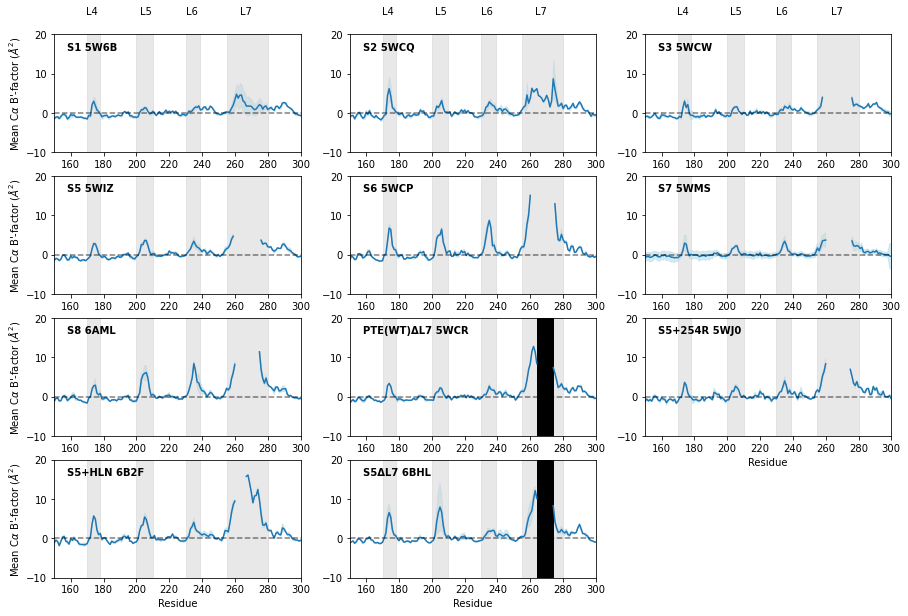

In [43]:
# PLOTTING AVERAGE NORMALISED B-FACTORS (S-TRAJ)
#This cell is used for deciding on places in multipanel figure

places = [1+i for i in range(len(Straj))]

ymin=-10
ymax=20
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1


# loop through each PDB ID
for pdb_id in Straj:

    file_name=f'{output_folder}/averagenorm/averages/{pdb_id}_averages.csv'
    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    #print(f"working on {pdb_id}")

    place = places[Straj.index(pdb_id)]    
    ax = fig.add_subplot(4,3,place)
    
    data= pd.read_csv(file_name)
    residue_number = data['Residue Number']
    average_bfactor = data['Average B-Factor']
    std_dev = data['Standard Deviation']
    ax.plot(residue_number, average_bfactor)
    # Create an array for the shaded region
    x = np.array(residue_number)
    y1 = average_bfactor - std_dev
    y2 = average_bfactor + std_dev

    # Shade the region within plus and minus standard deviation
    ax.fill_between(x, y1, y2, color='lightblue', alpha=0.5)

    # # Set labels and title
    # ax.set_xlabel('Residue Number')
    # ax.set_ylabel('Average B-Factor')
    # ax.set_title('Average B-Factor vs Residue Number')

    # color_count=0
    # for chain_id in pdb_rows['Chain ID'].unique():
    #     #print(f"working on {chain_id}")
    #     column_label = f"{pdb_id}_{nickname}_{chain_id}"
    #     residue_col_label=f"res_{pdb_id}_{nickname}_{chain_id}"
    #     # Get the rows corresponding to the current CHAIN ID and PDB ID
    #     chain_rows = pdb_rows[pdb_rows['Chain ID'] == chain_id]
    #     # nickname = chain_rows['NAME'].iloc[0]
    #     #print(nickname)

    #     # plot_chain_bfactor, ax1 = plt.subplots()
    #     # dataf = pd.DataFrame({'Residue Numbers': chain_rows['Residue Numbers'], 'Isotropic B-factor data': chain_rows['Isotropic B-factor data']})
    #     #print(dataf['Residue Numbers'].iloc[0])
    #     #print(dataf['Isotropic B-factor data'].iloc[0])

    #     residue_numbers_series = pd.Series(dataf['Residue Numbers'].iloc[0])
    #     csv_df[residue_col_label] = residue_numbers_series
        
    #     b_factors_series = pd.Series(dataf['Isotropic B-factor data'].iloc[0])
    #     csv_df[column_label] = b_factors_series
    #     #print("this is what is should look like before replacing with nan")
    #     #print(b_factors_series)
    #     b_factors_series = b_factors_series.replace(-1, np.nan)
    #     b_factors_list = list(b_factors_series)

    #     #interpolate in missing regions
    #     interpolated_points=[]
    #     interpolated_range=[]
    #     interpolated_b_factors = b_factors_series.interpolate()
    #     interpolated_points = b_factors_series.isna() & interpolated_b_factors.notna()
    #     #print("intopolated points are")
    #     #print(interpolated_points)
    #     non_missing_mask = b_factors_series.notna()

       
    #     # # Plot missing residues (B-factor equal to NaN interpolated)
    #     if True in interpolated_points:
    #         # Find the indices where interpolated points are True
    #         interpolated_indices = [i for i, val in enumerate(interpolated_points) if val]
            
    #         # Check if there are any missing regions
    #         if len(interpolated_indices) > 0:
    #             # Initialize variables for storing the start and end indices of each missing region
    #             missing_start = interpolated_indices[0]
    #             missing_end = interpolated_indices[0]
                
    #             # Loop through the interpolated indices to identify missing regions
    #             for index in interpolated_indices[1:]:
    #                 if index == missing_end + 1:
    #                     missing_end = index
    #                 else:
    #                     # Plot the missing region
    #                     ax.plot(residue_numbers_series.iloc[missing_start:missing_end+1], interpolated_b_factors.iloc[missing_start-1:missing_end+2], 'k:')
                        
    #                     # Update the start and end indices for the next missing region
    #                     missing_start = index
    #                     missing_end = index
                
    #             # Plot the last missing region
    #             # ax.plot(residue_numbers_series.iloc[missing_start-1:missing_end+2], interpolated_b_factors.iloc[missing_start-1:missing_end+2], 'k')
         
    #     # Plot non-missing residues
    #     # ax.scatter(residue_numbers_series[non_missing_mask], b_factors_series[non_missing_mask], label=f"{chain_id}",color=colors[color_count], zorder=5)
    #     ax.plot(residue_numbers_series[:missing_start], b_factors_series[:missing_start], label=f"{chain_id}",color=colors[color_count], zorder=5)
    #     ax.plot(residue_numbers_series[missing_end:], b_factors_series[missing_end:],color=colors[color_count], zorder=5)
        

    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas
    ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
    ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)
    plt.axhline(y=0, color='k', alpha=0.5, linestyle='dashed')

        
        
    if count in [8,12,13]:
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    else: 
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    #sets labels on axes    
    if count in [1,4,7,10]:
        ax.set_ylabel(r"Mean C$\alpha$ B'-factor ($\AA^2$)")
    if count in [9,10,11,12]:
        ax.set_xlabel('Residue')
    if count in [1,2,3]:
        ax.text(169.5, ymax+5, 'L4')
        ax.text(202, ymax+5, 'L5')
        ax.text(230, ymax+5, 'L6')
        ax.text(263, ymax+5, 'L7')    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)
    ax.text(xmin+8, ymax*0.8, nickname+' '+pdb_id,fontweight='bold')
    # ax.legend(loc='upper right', fontsize='small', markerscale=0.5)
    
    color_count=color_count+1
    count = count+1

    if pdb_id in ["5WCR","6BHL","6BHK"]:
        ax.axvspan(264, 274, color='black', zorder=1)

print(count)



# Save the DataFrame to a CSV file
#csv_df.to_csv('Straj_Bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Straj_AVERAGENORM_Bfactors_allchains.png', dpi=300)   


8


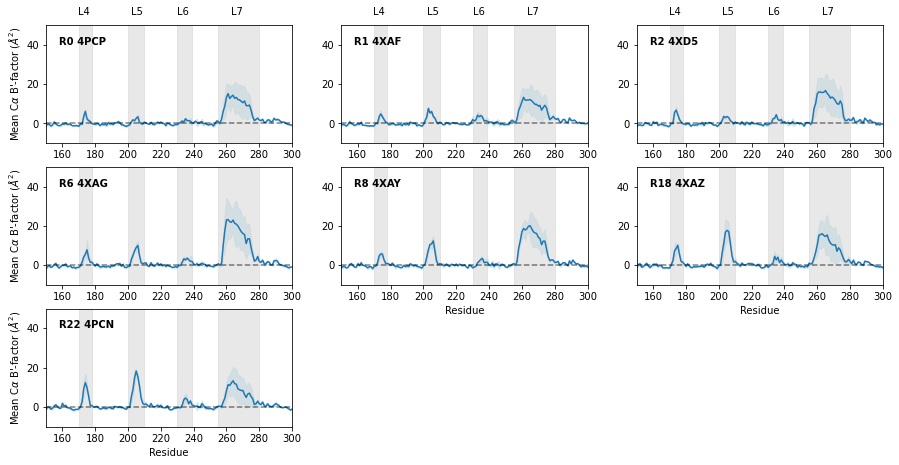

In [45]:
# PLOTTING AVERAGE NORMALISED B-FACTORS (R-TRAJ)
#This cell is used for deciding on places in multipanel figure

places = [1+i for i in range(len(Rtraj))]

ymin=-10
ymax=50
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1


# loop through each PDB ID
for pdb_id in Rtraj:

    file_name=f'{output_folder}/averagenorm/averages/{pdb_id}_averages.csv'
    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    #print(f"working on {pdb_id}")

    place = places[Rtraj.index(pdb_id)]    
    ax = fig.add_subplot(4,3,place)
    
    data= pd.read_csv(file_name)
    residue_number = data['Residue Number']
    average_bfactor = data['Average B-Factor']
    std_dev = data['Standard Deviation']
    ax.plot(residue_number, average_bfactor)
    # Create an array for the shaded region
    x = np.array(residue_number)
    y1 = average_bfactor - std_dev
    y2 = average_bfactor + std_dev

    # Shade the region within plus and minus standard deviation
    ax.fill_between(x, y1, y2, color='lightblue', alpha=0.5)

   
    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas
    ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
    ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
    ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)
    plt.axhline(y=0, color='k', alpha=0.5, linestyle='dashed')

        
        
    if count in [8,12,13]:
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    else: 
        ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    #sets labels on axes    
    if count in [1,4,7,10]:
        ax.set_ylabel(r"Mean C$\alpha$ B'-factor ($\AA^2$)")
    if count in [5,6,7,10,11,12]:
        ax.set_xlabel('Residue')
    if count in [1,2,3]:
        ax.text(169.5, ymax+5, 'L4')
        ax.text(202, ymax+5, 'L5')
        ax.text(230, ymax+5, 'L6')
        ax.text(263, ymax+5, 'L7')    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)
    ax.text(xmin+8, ymax*0.8, nickname+' '+pdb_id,fontweight='bold')
    # ax.legend(loc='upper right', fontsize='small', markerscale=0.5)
    
    color_count=color_count+1
    count = count+1

    if pdb_id in ["5WCR","6BHL","6BHK"]:
        ax.axvspan(264, 274, color='black', zorder=1)

print(count)



# Save the DataFrame to a CSV file
#csv_df.to_csv('Straj_Bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Rtraj_AVERAGENORM_Bfactors_allchains.png', dpi=300)   


8


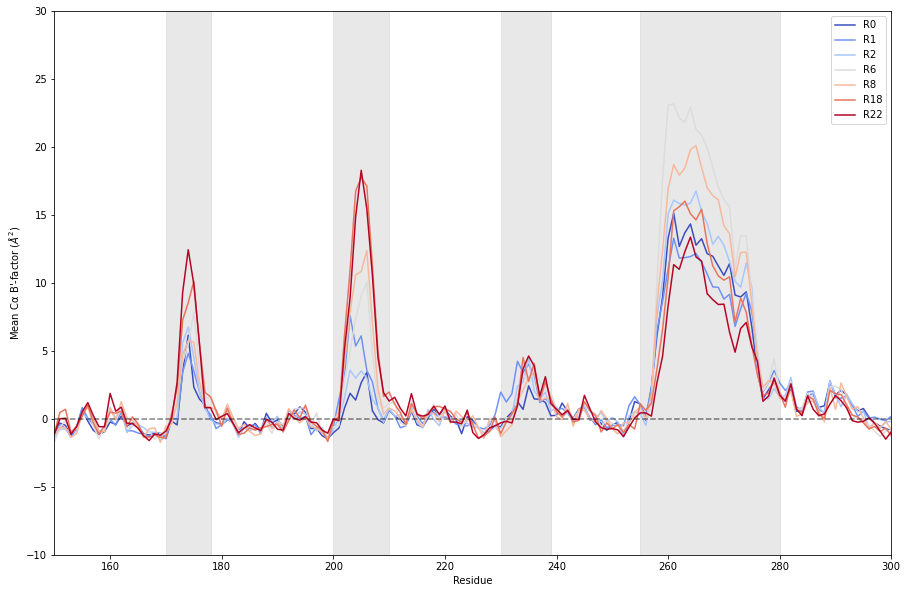

In [46]:
# PLOTTING AVERAGE NORMALISED B-FACTORS (R-TRAJ)
#This cell is used for deciding on places in multipanel figure
color=iter(plt.cm.coolwarm(np.linspace(0,1,7)))

ymin=-10
ymax=30
xmin=150
xmax=300
fig = plt.figure(figsize=(15,10))
count=1
ax = fig.add_subplot(111)

# loop through each PDB ID
for pdb_id in Rtraj:

    file_name=f"{output_folder}/averagenorm/averages/{pdb_id}_averages.csv"
    # Get the rows corresponding to the current PDB ID
    pdb_rows = summary_df[summary_df['PDB ID'] == pdb_id]
    nickname = pdb_rows['NAME'].iloc[0]
    #print(f"working on {pdb_id}")

    # place = places[Rtraj.index(pdb_id)]    
    # ax = fig.add_subplot(4,3,place)
    
    data= pd.read_csv(file_name)
    residue_number = data['Residue Number']
    average_bfactor = data['Average B-Factor']
    # std_dev = data['Standard Deviation']
    c=next(color)
    ax.plot(residue_number, average_bfactor, color=c, label=nickname)
    # Create an array for the shaded region
    # x = np.array(residue_number)
    # y1 = average_bfactor - std_dev
    # y2 = average_bfactor + std_dev

    # Shade the region within plus and minus standard deviation
    # ax.fill_between(x, y1, y2, color='lightblue', alpha=0.5)

   
    # DESIGN OF CHAIN B-FACTOR PLOT
    # colors grey shaded areas


        
        
    # if count in [8,12,13]:
    #     ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    # else: 
    #     ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
    
    # #sets labels on axes    
    # if count in [1,4,7,10]:
    #     ax.set_ylabel(r"C$\alpha$ B'-factor ($\AA^2$)")
    # if count in [10,11,12]:
    #     ax.set_xlabel('Residue')
    # if count in [1,2,3]:
    #     ax.text(169.5, ymax+5, 'L4')
    #     ax.text(202, ymax+5, 'L5')
    #     ax.text(230, ymax+5, 'L6')
    #     ax.text(263, ymax+5, 'L7')    

    # ax.text(xmin+8, ymax*0.8, nickname+' '+pdb_id,fontweight='bold')
    # # ax.legend(loc='upper right', fontsize='small', markerscale=0.5)


    # if pdb_id in ["5WCR","6BHL","6BHK"]:
    #     ax.axvspan(264, 274, color='black', zorder=1)

    color_count=color_count+1
    count = count+1



ax.axvspan(200, 210, alpha=0.5, color='lightgrey', zorder=1)
ax.axvspan(170, 178, alpha=0.5, color='lightgray', zorder=1)
ax.axvspan(230, 239, alpha=0.5, color='lightgray', zorder=1)
ax.axvspan(255, 280, alpha=0.5, color='lightgray', zorder=1)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin,xmax)
ax.set_ylabel("Mean Cα B'-factor ($\AA^2$)")
ax.set_xlabel("Residue")
plt.legend()
plt.axhline(y=0, color='k', alpha=0.5, linestyle='dashed')
print(count)



# Save the DataFrame to a CSV file
#csv_df.to_csv('Straj_Bfactors_data_perchain.csv', index=False)

plt.savefig(f'{output_folder}/Rtraj_AVERAGENORM_Bfactors_compare.png', dpi=300)   
